In [2]:

import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm
from collections import defaultdict
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt, cm
import csv


In [47]:

SMALL_VALUE=0.00001
ENTROPY_THRESHOLD = 0.001
MIN_STEP=2
training_data = pd.read_csv("./data/training_data.csv")
testing_data = pd.read_csv('./data/testing_data.csv')


In [48]:
def parse_command_string(command_str):
    # Convert the string representation of the list to an actual list
    return ast.literal_eval(command_str)

In [49]:
for index, row in testing_data.iterrows():
    if len(parse_command_string(row['commands'])) < MIN_STEP:
        testing_data.drop(index, inplace=True)
testing_data.index = range(len(testing_data))


In [50]:
temp=set()
for i in range(len(testing_data)):
    temp.add(len(parse_command_string(testing_data['commands'][i])))
MAX_STEP = max(temp)


In [ ]:
## Construction of Markov Chain

def create_markov_chain(commands, counts):
    markov_chain = defaultdict(lambda: defaultdict(int))
    
    for command, count in zip(commands, counts):
        # Add a transition from 'START' to the first state of the command
        markov_chain["START"][command[0]] += count
        for (current_state, next_state) in zip(command[:-1], command[1:]):
            markov_chain[current_state][next_state] += count

        markov_chain[command[-1]]["END"] += count


    return markov_chain


def _create_transition_matrix(markov_chain):
    """
    Create a transition matrix from the given Markov chain.
    Normalize the matrix so that rows sum to 1.
    """
    states = list(markov_chain.keys())
    transition_matrix = pd.DataFrame(0, index=states, columns=states)
    
    for current_state, transitions in markov_chain.items():
        total_transitions = sum(transitions.values())
        if total_transitions > 0:
            for next_state, count in transitions.items():
                transition_matrix.at[current_state, next_state] = count
    transition_matrix = transition_matrix.fillna(0)
    
    transition_matrix=transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    return transition_matrix

def draw_markov_chain(markov_chain):
    """
    Draw the Markov chain using networkx and matplotlib.
    """
    G = nx.DiGraph()
    
    for current_state, transitions in markov_chain.items():
        for next_state, count in transitions.items():
            G.add_edge(current_state, next_state, weight=count)
            
    pos = nx.spring_layout(G, k=2, iterations=50)  # Adjust the layout parameters for more spacing
    
    plt.figure(figsize=(13, 13))  # Increase figure size
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=12, font_weight="bold", arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    
    plt.title("Markov Chain")
    plt.show()

def draw_heatmap(transition_matrix):
    """
    Draw a heatmap of the transition matrix using seaborn with zero values colored green.
    """
    # Create a custom colormap that maps zero to green
    colors = [(0, "green"), (1, "white")]  # Map 0 to green and 1 to white
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
    
    plt.figure(figsize=(3, 3))
    # Apply the custom colormap to the heatmap
    sns.heatmap(transition_matrix, annot=True, cmap=cmap, fmt=".2f", vmin=0, vmax=1)
    plt.title("Transition Matrix Heatmap")
    plt.show()
    
def get_transition_matrix(label_value):
    # Filter rows based on the label value
    df_filtered = training_data[training_data['label'] == label_value].copy()

    # Parse the command column
    df_filtered.loc[:, 'command'] = df_filtered['command'].apply(parse_command_string)

    # Generate Markov chain from the commands
    all_commands = df_filtered['command'].tolist()
    all_counts = df_filtered['total count'].tolist()

    markov_chain = create_markov_chain(all_commands, all_counts)
    transition_matrix = _create_transition_matrix(markov_chain)
    
    return transition_matrix

def transition_probability(transition_matrix, start_state, end_state):
    """
    Calculate the probability of transitioning from one state to another in a single step.
    If either state is not found or the transition probability is 0, return 0.00001.

    Parameters:
    - transition_matrix (pd.DataFrame): Transition matrix as a pandas DataFrame.
    - start_state (str or int): The starting state.
    - end_state (str or int): The ending state.

    Returns:
    - float: Probability of transitioning from start_state to end_state in one step,
             or 0.00001 if either state is not found or the probability is 0.
    """
    # Return 0.00001 if start or end state is not in the transition matrix
    if start_state not in transition_matrix.index or end_state not in transition_matrix.columns:
        return SMALL_VALUE

    # Retrieve the probability directly
    start_idx = transition_matrix.index.get_loc(start_state)
    end_idx = transition_matrix.columns.get_loc(end_state)
    probability = transition_matrix.iloc[start_idx, end_idx]

    # Return 0.00001 if the probability is 0
    return probability if probability != 0 else SMALL_VALUE

def prob_sequence_in_cluster(transition_matrix, sequence):
    curr_prob = 1
    for i in range(len(sequence)-1):
        curr_prob *= transition_probability(transition_matrix, sequence[i],sequence[i+1])
    return curr_prob



In [52]:
possible_cluster = list(set(training_data['label']))

cluster_to_matrix = dict()
for i in possible_cluster:
    cluster_to_matrix[i] = get_transition_matrix(i)

In [53]:
prior_dict = dict()
total_count = sum(training_data['total count'])
    
for i in possible_cluster:
    prior_dict[i]=sum(training_data.loc[training_data['label'] == i]['total count'])/total_count

In [54]:
# TODO: currently this is "option 1" from prof. dalal's note. change if needed.
def prior(i):
    return prior_dict[i] # Option 2
    #return 1/len(possible_cluster) # Option 1

def p(sequence):
    ret_dict = dict()
    ret_list = list()
    total = 0
    for i in possible_cluster:
        curr = prob_sequence_in_cluster(cluster_to_matrix[i], sequence) * prior(i)
        ret_dict[i]= curr
        total += curr
    
    for i in possible_cluster:
        ret_dict[i] = ret_dict[i] / total
        ret_list.append(ret_dict[i])

    return (ret_dict, possible_cluster, ret_list)

def run_n_steps(sequence, steps, append_start=False):
    seq = sequence[:steps]
    if append_start:
        seq.insert(0, "START")
    return p(seq)

def ent(prob):
    #computes entropy of a prob vector-
    #prob has to be non-negative and adds up to 1.
    prob=np.array(prob)
    prob=prob[np.where(prob>0)]
    return(-np.dot(prob,np.log2(prob)))

def prob_entropy(prob,categories):
  px=np.array(prob)
  px=px/sum(px)
  # Create a bar chart and computer entropy
  plt.figure(figsize=(4,2))
  plt.bar(categories, px)
  plt.xlabel('Categories')
  plt.ylabel('Probabilities')
  plt.title('Distribution')
  # Display the chart
  plt.show()
  return(ent(prob))
        

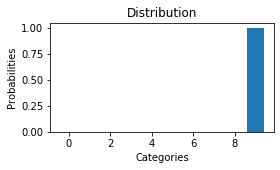

0.01179450582130521

In [55]:
test=parse_command_string(testing_data['commands'][2])
d, cat, prob = run_n_steps(test,4, False)
entropy=prob_entropy(prob, cat)

entropy

In [56]:
entropy_over_time = dict()
group_over_time = dict()
right_value_moment = dict()
ground_truth_dict = dict()
for session in list(testing_data["session"]):
    entropy_over_time[session] = list()
    right_value_moment[session] = -1

In [57]:
def get_ground_truth(append_start=True):
    sessions = list()
    sequences = list()
    ground_truths = list()
    entropies = list()
    
    for i in range(len(testing_data)):
        test=parse_command_string(testing_data['commands'][i])
        
        d, cat, prob = run_n_steps(test,len(test), append_start=append_start)
        entropy=ent(prob)
        

        v = list(d.values())
        k = list(d.keys())
        ground_truth = k[v.index(max(v))]
        
        session = testing_data['session'][i]
        
        sessions.append(session)
        sequences.append(test)
        ground_truths.append(ground_truth)
        entropies.append(entropy)
        
        ground_truth_dict[session] = ground_truth

        if entropy > ENTROPY_THRESHOLD:
            print(f"Session {testing_data['session'][i]} has high entropy of {entropy}")
    df = pd.DataFrame()
    df["session"] = sessions
    df["sequence"] = sequences
    df["ground_truth"] = ground_truths
    df["entropy"] = entropies
    return df


In [ ]:
grounds = get_ground_truth(True)
grounds.to_csv("./data/ground_truth.csv")

Session 0746247aa68a has high entropy of 0.11868219694237274
Session 0892671fbc80 has high entropy of 0.11868219694237274
Session 102f1d2958d1 has high entropy of 0.11868219694237274
Session 1e1f099bcb9b has high entropy of 0.11868219694237274
Session 2249f30eb4d1 has high entropy of 0.42183645828036204
Session 460b7cfa2463 has high entropy of 0.42183645828036204
Session 6f3aac271eca has high entropy of 0.42183645828036204
Session 78a7f4cc8125 has high entropy of 0.11868219694237274
Session 96b5f84ccdc7 has high entropy of 0.42183645828036204
Session c5cc9ad77e1c has high entropy of 0.42183645828036204
Session d2c833552ddf has high entropy of 0.11868219694237243
Session f6ded7e5b6a8 has high entropy of 0.42183645828036204


In [59]:
def run_test_step(step=2, append_start=True):
    
    for i in range(len(testing_data)):
        test=parse_command_string(testing_data['commands'][i])
        if len(test)<step:
            continue
        
        d, cat, prob = run_n_steps(test,step, append_start=append_start)
        entropy=ent(prob)
        

        
        # if entropy > ENTROPY_THRESHOLD:
        #     print(f"Session {testing_data['session'][i]} has entropy of {entropy}")
        #     print(test)
        #     print(d)
        #     print("==================")


In [61]:
def run_test(append_start=True):
    for session in list(testing_data["session"]):
        entropy_over_time[session] = list()
        group_over_time[session] = list()

        
        right_value_moment[session] = -1
        
    list_not_matched = list()
    
    debug = False
    for step in range(1,MAX_STEP+1): 
        print(f"Runing steps of {step} out of {MAX_STEP}")
        for i in range(len(testing_data)):
            session=testing_data['session'][i]
            # if session == "fff9cebbd635":
            #     debug = True
            # else:
            #     debug = False
            
            test=parse_command_string(testing_data['commands'][i])
            if debug:
                print("test command", test, i)
                
            if len(test)<step:
                continue
            
            d, cat, prob = run_n_steps(test, step, append_start=append_start)
            if debug:
                print(d)
                print(prob)

            entropy=ent(prob) 
            v = list(d.values())
            k = list(d.keys())
            committed_group = k[v.index(max(v))]

            if debug:
                print("entropy", entropy)
                print("committed to", committed_group)
            
            if ground_truth_dict[session] != committed_group:
                list_not_matched.append((step, entropy))
            
            
            if ground_truth_dict[session] == committed_group and right_value_moment[session] == -1:
                right_value_moment[session] = step
            group_over_time[session].append(committed_group)
            entropy_over_time[session].append(entropy)
            if debug:
                print("dictionary", entropy_over_time[session])
    return (right_value_moment, entropy_over_time, list_not_matched, group_over_time)
            

In [62]:
rvm, eot, lnm, got = run_test()

Runing steps of 1 out of 25
Runing steps of 2 out of 25
Runing steps of 3 out of 25
Runing steps of 4 out of 25
Runing steps of 5 out of 25
Runing steps of 6 out of 25
Runing steps of 7 out of 25
Runing steps of 8 out of 25
Runing steps of 9 out of 25
Runing steps of 10 out of 25
Runing steps of 11 out of 25
Runing steps of 12 out of 25
Runing steps of 13 out of 25
Runing steps of 14 out of 25
Runing steps of 15 out of 25
Runing steps of 16 out of 25
Runing steps of 17 out of 25
Runing steps of 18 out of 25
Runing steps of 19 out of 25
Runing steps of 20 out of 25
Runing steps of 21 out of 25
Runing steps of 22 out of 25
Runing steps of 23 out of 25
Runing steps of 24 out of 25
Runing steps of 25 out of 25


In [63]:
switched_ones_session = list()

for k in rvm.keys():
    v=rvm[k]
    if v != 1:
        switched_ones_session.append(k)
        print(k,v)
        print(got[k])
        print("=======================")

091218400063 10
[9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0a60c5b06bca 6
[3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0cd946a465b4 10
[9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
12e0e10152a1 10
[9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2149b016aa3f 6
[3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2249f30eb4d1 3
[0, 0, 5, 5, 5]
23fb4e8afd47 6
[3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2af0676d1586 10
[9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2ccb2b59d59b 10
[9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4502907b5eee 10
[9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
460b7cfa2463 3
[0, 0, 5, 5, 5]
5e78936e55f6 6
[3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6f3aac271eca 3
[0, 0, 5, 5, 5]
94e9587d1a87 10
[9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
with open("./results/switched_ones.csv", mode='w', newline='') as file:

    header = ['position', 'wrong entropy', 'correct entropy']
    writer = csv.DictWriter(file, fieldnames = header)
     
    # writing data row-wise into the csv file
    writer.writeheader()
    for s in switched_ones_session:
        ground_truth= ground_truth_dict[s]  
        print(ground_truth, s) 

        for i in range(len(eot[s])):
            if got[s][i]!= ground_truth:
                writer.writerow( {"position":i,
                                 "wrong entropy": eot[s][i]})
            else:
                 writer.writerow( {"position":i,
                                 "correct entropy": eot[s][i]})



0 091218400063
0 0a60c5b06bca
0 0cd946a465b4
0 12e0e10152a1
0 2149b016aa3f
5 2249f30eb4d1
0 23fb4e8afd47
0 2af0676d1586
0 2ccb2b59d59b
0 4502907b5eee
5 460b7cfa2463
0 5e78936e55f6
5 6f3aac271eca
0 94e9587d1a87
5 96b5f84ccdc7
0 97f35ef44c50
0 ab296ff5e2df
0 baff530932ce
0 bde2165a93ac
5 c5cc9ad77e1c
0 cf43d9726a23
5 f6ded7e5b6a8


## Accuracy Test


In [ ]:
# Get the maximum length of lists in the dictionary values
max_len = MAX_STEP
# Pad lists to ensure all rows have the same number of columns
padded_data = {key: value + [''] * (max_len - len(value)) for key, value in entropy_over_time.items()}

# Write the data to a CSV file
with open("./results/entropy_over_steps.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write each key and its corresponding list to the file
    for key, value in padded_data.items():
        writer.writerow([key] + value)



In [ ]:
position_value_data = []
for key, values in entropy_over_time.items():
    for pos, value in enumerate(values):
        position_value_data.append([pos, value])

# Write to CSV
with open("./results/entropy_to_be_graphed.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Position', 'Value'])  # Write header
    writer.writerows(position_value_data)  # Write data rows

In [ ]:
position_value_data = []
for key, values in rvm.items():
   
    position_value_data.append([key, value])

# Write to CSV
with open("./results/right_value_moment.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['session', 'step'])  # Write header
    writer.writerows(position_value_data)  # Write data rows

In [ ]:
with open("./results/entropy_bad.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Position', 'Value'])  # Write header
    writer.writerows(lnm)  # Write data